# Biodiversity data - Codecademy Portfolio Project

We will be exploring two CSV files:

* species_info.csv - contains data about different species and their conservation status
* observations.csv - holds recorded sightings of different species at several national parks for the past 7 days.

species_info.csv:

* category - class of animal
* scientific_name - the scientific name of each species
* common_name - the common names of each species
* conservation_status - each species’ current conservation status

observations.csv:

* scientific_name - the scientific name of each species
* park_name - Park where species were found
* observations - the number of times each species was observed at park

### Import Python Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from IPython.display import display
# from tabulate import tabulate

## Data file species_info.csv

### Loading

In [3]:
species_info = pd.read_csv('species_info.csv')
# print(tabulate(species_info.head(), headers='keys', tablefmt='pretty'))
display(species_info.head())

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


### Columns data types and counts

In [29]:
species_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB


In [46]:
maxRows = species_info['category'].count()
print('Missing Data:')
percent = (1 - species_info.count() / maxRows) * 100
print(percent.apply(lambda x: '{:.2f}%'.format(x)))

Missing Data:
category                0.00%
scientific_name         0.00%
common_names            0.00%
conservation_status    96.72%
dtype: object


### Observations

* The conservation_status column seem to contains mosty NaN values. Only about 3% non-missing values.
* The other three columns do not seem to miss data.

### Categories for the columns + Adding column

In [6]:
print(species_info.category.value_counts())
print()
print(species_info.scientific_name.value_counts())
print()
print(species_info.common_names.value_counts())
print()
print(species_info.conservation_status.value_counts())
print()
species_info['is_endangered'] = ~species_info['conservation_status'].isnull()
print(species_info['is_endangered'].value_counts())


category
Vascular Plant       4470
Bird                  521
Nonvascular Plant     333
Mammal                214
Fish                  127
Amphibian              80
Reptile                79
Name: count, dtype: int64

scientific_name
Procyon lotor             3
Myotis lucifugus          3
Canis lupus               3
Castor canadensis         3
Hypochaeris radicata      3
                         ..
Solanum parishii          1
Solanum xanti             1
Parthenocissus vitacea    1
Vitis californica         1
Saxifraga oregana         1
Name: count, Length: 5541, dtype: int64

common_names
Brachythecium Moss                                                            7
Dicranum Moss                                                                 7
Bryum Moss                                                                    6
Panic Grass                                                                   6
Sphagnum                                                                      6
    

### Observations

* The columns **category** and **conservation_status** contains substantial categories
* About 80% of the "animals" in the dataset are **plants**.
* The columns **scientific_name** and **common_names** contain strings, and are mostly different for each row
* For **conservation_status** 
  * Only about 3% of the data are not missing
  * The values 'Species of Concern', 'Endangered' and 'Threatened' seem to mean the same.  
The fourth value 'In Recovery' seems also to mean 'of concern' but perhaps more specific.
* Accordingly, I added a new column **of_concern** which is true iff conservation_status is not null

### Distribution by Species Category

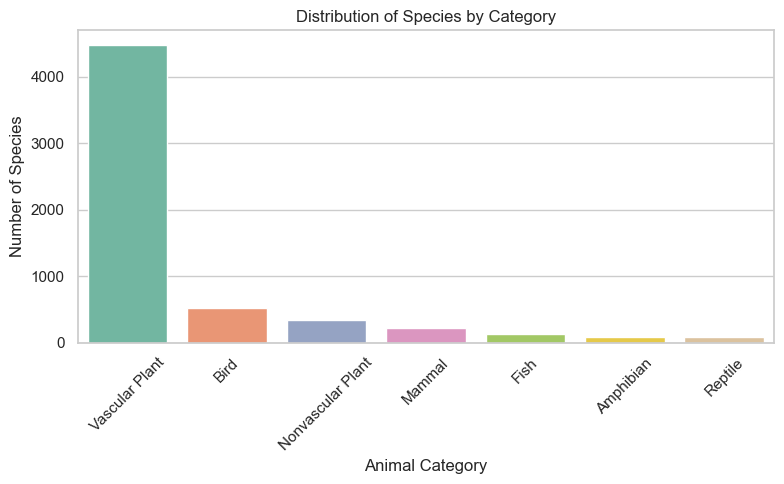

In [30]:
# Count the number of species in each category
category_counts = species_info['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']

# Plotting the bar chart with updated practices
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(
    data=category_counts,
    x='category',
    y='count',
    hue='category',  # Assign x variable to hue for unique bar colors
    dodge=False,     # Prevent bars from being grouped by hue
    palette='Set2',
    legend=False     # Disable legend as we don't need it in this case
)
plt.title('Distribution of Species by Category')
plt.xlabel('Animal Category')
plt.ylabel('Number of Species')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.tight_layout()       # Prevent overlap of labels
plt.show()

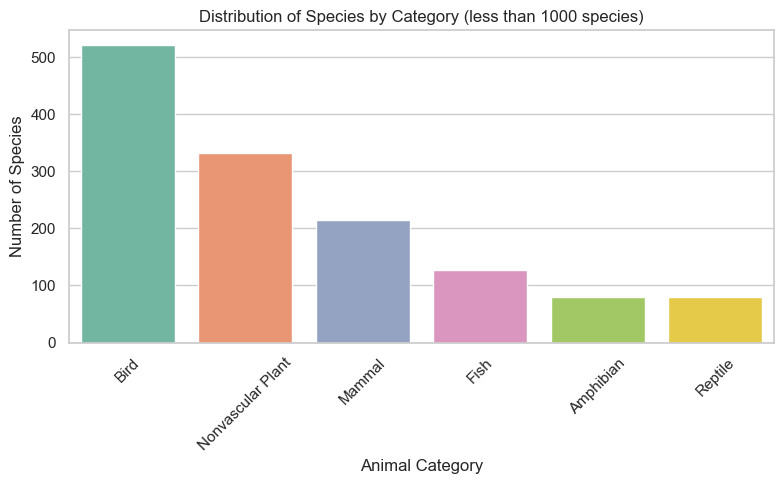

In [31]:
# Display only categories with less than 1000 species
category_counts_small = category_counts[category_counts['count'] < 1000]

# Plotting the bar chart with updated practices
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(
    data=category_counts_small,
    x='category',
    y='count',
    hue='category',  # Assign x variable to hue for unique bar colors
    dodge=False,     # Prevent bars from being grouped by hue
    palette='Set2',
    legend=False     # Disable legend as we don't need it in this case
)
plt.title('Distribution of Species by Category (less than 1000 species)')
plt.xlabel('Animal Category')
plt.ylabel('Number of Species')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.tight_layout()       # Prevent overlap of labels
plt.show()

### Observations

* The Vascular Plant category is by far the most populated category in the dataset. In has about 10 times more species than the next category in size, which is Birds.

### Missing conservation_status data per species category

Let's see if there is a visible relationship between species category and missing data on conservation status.

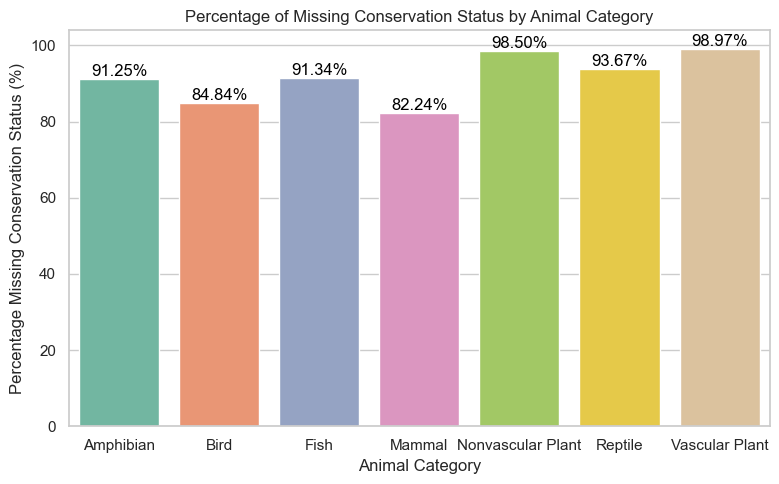

In [64]:
# Group the DataFrame and compute the percentages
agg_df = species_info.groupby('category').agg(
    total_instances=('conservation_status', 'size'),
    missing_count=('conservation_status', lambda x: x.isnull().sum())
).reset_index()

# Calculate percentage and format it for printing
agg_df['missing_percentage'] = (agg_df['missing_count'] / agg_df['total_instances']) * 100
agg_df['formatted_percentage'] = agg_df['missing_percentage'].map("{:.2f}%".format)

# print("Percentage of missing 'conservation_status' values by animal category:")
# print(agg_df[['category', 'formatted_percentage']])

# Plot using seaborn to visualize percentages
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
barplot = sns.barplot(
    data=agg_df,
    x='category',
    y='missing_percentage',
    palette='Set2',
    hue='category',
    legend=False
)

barplot.set_title('Percentage of Missing Conservation Status by Animal Category')
barplot.set_xlabel('Animal Category')
barplot.set_ylabel('Percentage Missing Conservation Status (%)')

# Add data labels showing the percentages above each bar
for index, row in agg_df.iterrows():
    barplot.text(
        index, row['missing_percentage'],
        f"{row['missing_percentage']:.2f}%",
        color='black', ha="center", va="bottom"
    )

plt.tight_layout()
plt.show()


### Observations

The missing values in conservation status seem nearly evenly distributed amoung the species categories.  
There is no visible correlations between missing values and species category.

### Endangered species per species category

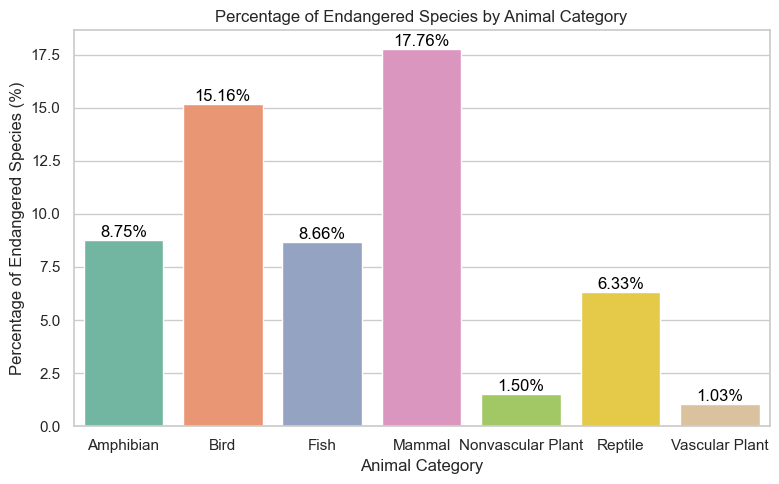

In [70]:
# Group the DataFrame and calculate the percentage of endangered species
agg_df = species_info.groupby('category').agg(
    total_instances=('is_endangered', 'size'),
    endangered_count=('is_endangered', 'sum')
).reset_index()

# Calculate percentage of endangered species
agg_df['endangered_percentage'] = (agg_df['endangered_count'] / agg_df['total_instances']) * 100

# print("Percentage of endangered species by animal category:")
# agg_df['formatted_percentage'] = agg_df['endangered_percentage'].map("{:.2f}%".format)
# print(agg_df[['category', 'formatted_percentage']])

# Plot using seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
barplot = sns.barplot(
    data=agg_df,
    x='category',
    y='endangered_percentage',
    palette='Set2',
    hue='category',
    legend=False
)

barplot.set_title('Percentage of Endangered Species by Animal Category')
barplot.set_xlabel('Animal Category')
barplot.set_ylabel('Percentage of Endangered Species (%)')

# Add percentage labels above bars
for index, row in agg_df.iterrows():
    barplot.text(
        index, row['endangered_percentage'],
        f"{row['endangered_percentage']:.2f}%",
        color='black', ha="center", va="bottom"
    )

plt.tight_layout()
plt.show()

### Observations

We can see that most species that are indicated as endangered in the dataset are either mammals or birds.  
Relatively few of the plants species are considered endangered.

## Data file observations.csv

### Loading

In [4]:
observations = pd.read_csv('observations.csv')
display(observations.head())

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


### Columns data types and counts

In [5]:
observations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23296 non-null  object
 1   park_name        23296 non-null  object
 2   observations     23296 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 546.1+ KB


### Observations

There are no missing data in the observations dataset.

### Park names

In [6]:
observations.park_name.value_counts()

park_name
Great Smoky Mountains National Park    5824
Yosemite National Park                 5824
Bryce National Park                    5824
Yellowstone National Park              5824
Name: count, dtype: int64

### Observations

The observations dataset contain data on observations of animals and plants in four parks.  
Judging by the number of rows, it seems that for each of the four parks we have a row for every species in the species_info dataset.

### Merging the two datasets

In [28]:
# Merge the dataframes on 'scientific_name'
merged_df = pd.merge(observations, species_info, on='scientific_name')

# Aggregate data: calculate total and endangered observations for each park and category
agg_df = merged_df.groupby(['park_name', 'category']).agg(
    total_observations=('observations', 'sum'),
    endangered_observations=('is_endangered', lambda x: (x * merged_df.loc[x.index, 'observations']).sum())
).reset_index()

print("Aggregated observations data:")
display(agg_df)

Aggregated observations data:


,park_name,category,total_observations,endangered_observations
0,Bryce National Park,Amphibian,7542,498
1,Bryce National Park,Bird,58590,7608
2,Bryce National Park,Fish,12823,731
3,Bryce National Park,Mammal,28830,4701
4,Bryce National Park,Nonvascular Plant,32992,486
5,Bryce National Park,Reptile,8141,387
6,Bryce National Park,Vascular Plant,484373,4198
7,Great Smoky Mountains National Park,Amphibian,5876,333
8,Great Smoky Mountains National Park,Bird,42869,5297
9,Great Smoky Mountains National Park,Fish,9482,547


### Observations by Category for each Park

Since there are much more observations in the "Vascular Plant" category, I will visuaize that category in a separate graph.

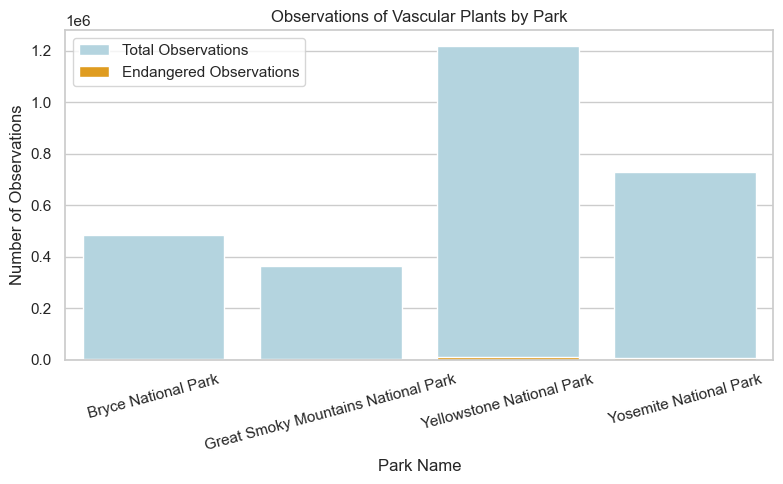

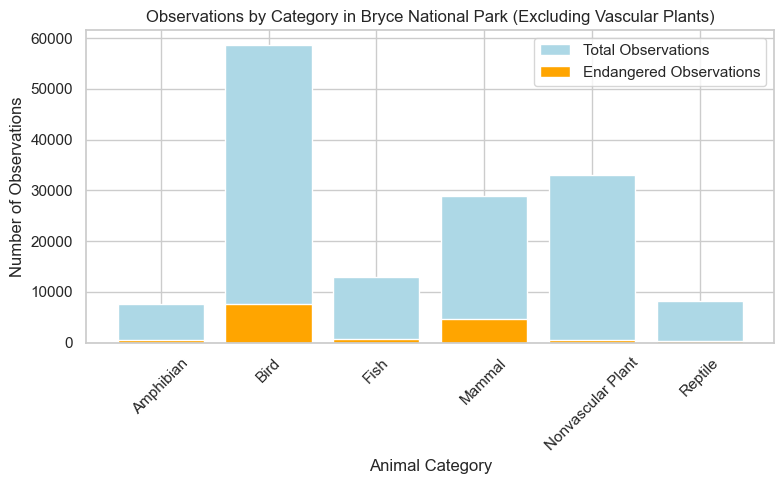

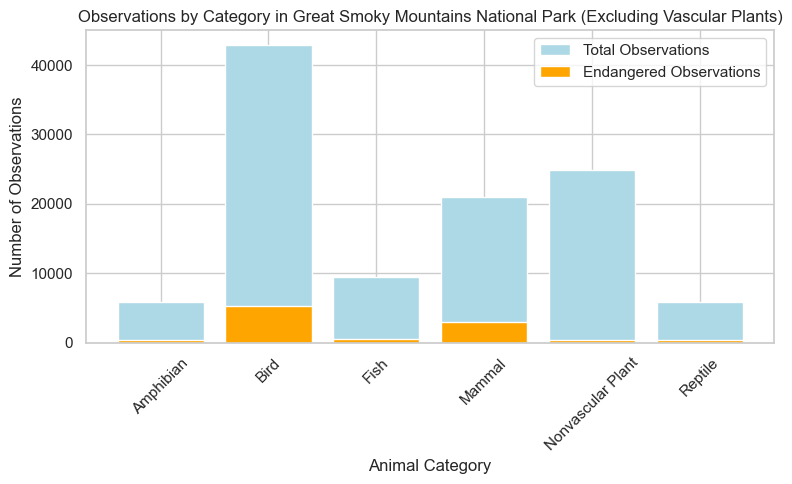

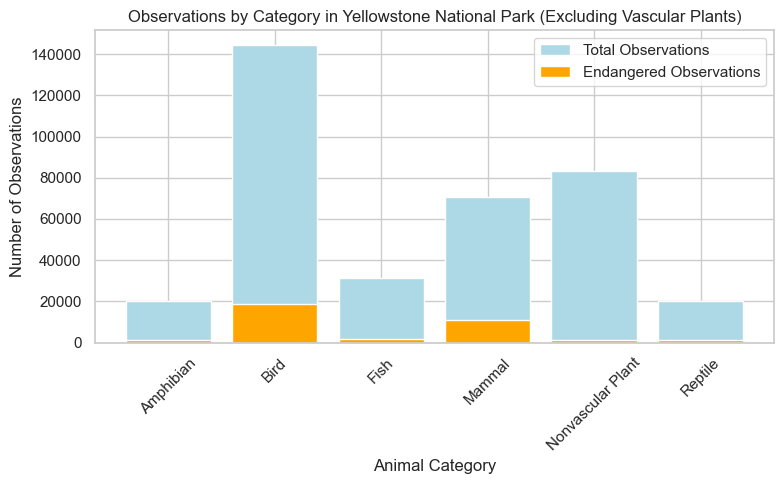

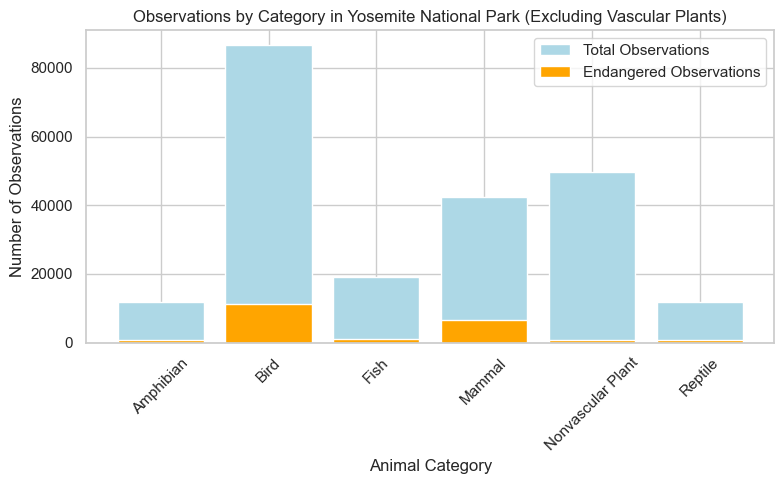

In [27]:
# Assuming 'agg_df' contains the aggregated data from the previous steps
# Splitting the data into "Vascular Plant" and other categories
vascular_plant_data = agg_df[agg_df['category'] == 'Vascular Plant']
other_categories_data = agg_df[agg_df['category'] != 'Vascular Plant']

# Plot for "Vascular Plant" category by park
plt.figure(figsize=(8, 5))
sns.barplot(
    data=vascular_plant_data,
    x='park_name',
    y='total_observations',
    color='lightblue',
    label='Total Observations'
)
sns.barplot(
    data=vascular_plant_data,
    x='park_name',
    y='endangered_observations',
    color='orange',
    label='Endangered Observations'
)
plt.title('Observations of Vascular Plants by Park')
plt.xlabel('Park Name')
plt.ylabel('Number of Observations')
plt.xticks(rotation=15)  # Rotate labels for clarity
plt.legend()
plt.tight_layout()
plt.show()

# Plot for each park (other categories)
parks = other_categories_data['park_name'].unique()

for park in parks:
    park_data = other_categories_data[other_categories_data['park_name'] == park]
    
    plt.figure(figsize=(8, 5))
    plt.bar(
        park_data['category'],
        park_data['total_observations'],
        label='Total Observations',
        color='lightblue'
    )
    plt.bar(
        park_data['category'],
        park_data['endangered_observations'],
        label='Endangered Observations',
        color='orange'
    )
    plt.title(f'Observations by Category in {park} (Excluding Vascular Plants)')
    plt.xlabel('Animal Category')
    plt.ylabel('Number of Observations')
    plt.xticks(rotation=45)  # Rotate labels for clarity
    plt.legend()
    plt.tight_layout()
    plt.show()
